In [126]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix,bmat
import gc

from sklearn.preprocessing import LabelBinarizer

import xgboost as xgb

%matplotlib inline
import matplotlib.pyplot as plt

In [113]:
cats = ['Green','Fairway','Intermediate Rough','Primary Rough','Fringe','Bunker','Other']

In [146]:
data = pd.concat([pd.read_csv('./../data/%d.csv' % year)[['Cat','Shots_taken_from_location','Started_at_Z',
        'Distance_from_hole','Hole','Round','Course_#','Year','Green_to_work_with']] for year in range(2003,2017)])

In [147]:
data = data[data.Cat=='Fairway']

In [148]:
test_inds = np.random.choice(range(len(data)),len(data)/5,replace=False)
test_set = set(test_inds.tolist())
train_inds = np.array([ind for ind in range(len(data)) if ind not in test_set])
train = data.iloc[train_inds,:]
test = data.iloc[test_inds,:]
data = None
gc.collect();

In [149]:
len(train),len(test)

(1911202, 477800)

In [150]:
train.insert(len(train.columns),'Year-Course',train.Year.astype(str).str.cat(train['Course_#'].astype(str),sep='-'))
test.insert(len(test.columns),'Year-Course',test.Year.astype(str).str.cat(test['Course_#'].astype(str),sep='-'))
train.insert(len(train.columns),'Hole-Course',train.Hole.astype(str).str.cat(train['Course_#'].astype(str),sep='-'))
test.insert(len(test.columns),'Hole-Course',test.Hole.astype(str).str.cat(test['Course_#'].astype(str),sep='-'))

train.insert(len(train.columns),'Hole-Year-Course',train.Hole.astype(str).str.cat(
                                    [train.Year.astype(str),train['Course_#'].astype(str)],sep='-'))
test.insert(len(test.columns),'Hole-Year-Course',test.Hole.astype(str).str.cat(
                                    [test.Year.astype(str),test['Course_#'].astype(str)],sep='-'))
train.insert(len(train.columns),'Round-Year-Course',train.Round.astype(str).str.cat(
                                    [train.Year.astype(str),train['Course_#'].astype(str)],sep='-'))
test.insert(len(test.columns),'Round-Year-Course',test.Round.astype(str).str.cat(
                                    [test.Year.astype(str),test['Course_#'].astype(str)],sep='-'))

train.insert(len(train.columns),'Hole-Round-Year-Course',train.Hole.astype(str).str.cat(
                        [train.Round.astype(str),train.Year.astype(str),train['Course_#'].astype(str)],sep='-'))
test.insert(len(test.columns),'Hole-Round-Year-Course',test.Hole.astype(str).str.cat(
                        [test.Round.astype(str),test.Year.astype(str),test['Course_#'].astype(str)],sep='-'))

In [151]:
test.head(3)

,Cat,Shots_taken_from_location,Started_at_Z,Distance_from_hole,Hole,Round,Course_#,Year,Green_to_work_with,Year-Course,Hole-Course,Hole-Year-Course,Round-Year-Course,Hole-Round-Year-Course
372220,Fairway,3.0,4.745,351.433705,10,2,538,2009,42.370538,2009-538,10-538,10-2009-538,2-2009-538,10-2-2009-538
576847,Fairway,3.0,-39.874,345.640303,9,2,27,2003,73.268610,2003-27,9-27,9-2003-27,2-2003-27,9-2-2003-27
348342,Fairway,3.0,-4.716,428.384479,6,2,19,2016,20.271045,2016-19,6-19,6-2016-19,2-2016-19,6-2-2016-19


In [152]:
lbins = {}

In [153]:
X_train = csr_matrix(train.values[:,np.array([2,3,8])].astype(float))
for col in [6,9,10,11,12,13]:
    lbins[col] = LabelBinarizer(sparse_output=True)
    lbins[col].fit(train.values[:,col].astype(str))
    X_train = bmat([[X_train,lbins[col].transform(train.values[:,col].astype(str))]],format='csr')

In [154]:
y_train = train.Shots_taken_from_location.values

In [155]:
train = None
gc.collect();

In [156]:
X_test = csr_matrix(test.values[:,np.array([2,3,8])].astype(float))
for col in [6,9,10,11,12,13]:
    X_test = bmat([[X_test,lbins[col].transform(test.values[:,col].astype(str))]],format='csr')

In [157]:
y_test = test.Shots_taken_from_location.values

In [158]:
test = None
gc.collect();

In [159]:
assert X_train.shape[1]==X_test.shape[1]

In [160]:
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

In [161]:
X_train,X_test,y_train,y_test = None,None,None,None
gc.collect();

In [194]:
params = {'objective':'reg:linear','silent':0,'eta':.03,'max_depth':6,'subsample':.5,'min_child_weight':5,
          'alpha':.3,'lambda':1.5}
watchlist  = [(dtrain,'train'),(dtest,'eval')]
num_round = 100000

In [ ]:
bst = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=25)

[0]	train-rmse:2.44584	eval-rmse:2.44551
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 25 rounds.
[1]	train-rmse:2.37643	eval-rmse:2.3761
[2]	train-rmse:2.30923	eval-rmse:2.30891
[3]	train-rmse:2.24415	eval-rmse:2.24383
[4]	train-rmse:2.18115	eval-rmse:2.18082
[5]	train-rmse:2.12013	eval-rmse:2.11981
[6]	train-rmse:2.06109	eval-rmse:2.06077
[7]	train-rmse:2.00395	eval-rmse:2.00363
[8]	train-rmse:1.94867	eval-rmse:1.94834
[9]	train-rmse:1.89519	eval-rmse:1.89487
[10]	train-rmse:1.84345	eval-rmse:1.84313
[11]	train-rmse:1.79342	eval-rmse:1.7931
[12]	train-rmse:1.74502	eval-rmse:1.7447
[13]	train-rmse:1.69821	eval-rmse:1.6979
[14]	train-rmse:1.65295	eval-rmse:1.65264
[15]	train-rmse:1.6092	eval-rmse:1.60889
[16]	train-rmse:1.56693	eval-rmse:1.56663
[17]	train-rmse:1.52608	eval-rmse:1.52578
[18]	train-rmse:1.48661	eval-rmse:1.48632
[19]	train-rmse:1.4485	eval-rmse:1.44821
[20]	train-rmse:1.41171	eval-rmse

In [199]:
0.559475**2

0.31301227562499995

In [97]:
errors

[0.31767960000361367,
 0.31713402466352247,
 0.31707661772969548,
 0.31703796538369622,
 0.31696640577471807,
 0.3169457449031795]

In [77]:
for arg,num in zip(np.argsort(gbr.feature_importances_)[::-1],np.sort(gbr.feature_importances_)[::-1])[0:7]:
    print arg,num

1 0.636828952947
0 0.113041097487
2 0.0753147335021
4 0.0202896295918
79 0.0144708131332
8 0.0132080876243
50 0.0116947970265


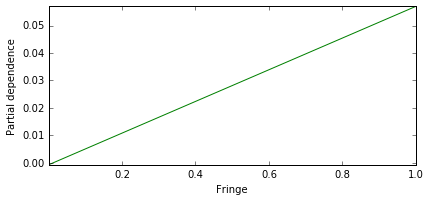

In [79]:
fig,axs = plot_partial_dependence(gbr,X_train_m2,[4],feature_names=,n_jobs=1,grid_resolution=50)

In [31]:
np.mean(((lcv.predict(normalizer.transform(X_test)) + gbr.predict(X_test_m))/2 - y_test)**2)

0.32071714739781892

In [ ]:
(((data.Cat=="Green").sum()*0.11545806607753986 +
 (data.Cat=="Fairway").sum()*0.31740937289 +
 (data.Cat=="Intermediate Rough").sum()*0.300202209856 +
 (data.Cat=="Primary Rough").sum()*0.361347962243 +
 (data.Cat=="Fringe").sum()*0.182508595153 + 
 (data.Cat=="Bunker").sum()*0.372257282426 +
 (data.Cat=="Other").sum()*0.493646743899)/len(data))**.5

In [ ]:
data = data[data.Cat=="Green"]

In [ ]:
X = data.values[:,2:].astype(float)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
pca = PCA()

In [ ]:
X_s = scaler.fit_transform(X)
X_t = pca.fit_transform(X_s)

In [ ]:
X_t.shape

In [ ]:
pca.explained_variance_ratio_

In [ ]:
np.dot(X_t,pca.components_)[0]

In [ ]:
pca.components_

In [ ]:
plt.scatter(X_t[:,0],X_t[:,1],alpha=.03)

In [ ]:
y = data.values[:,0]

In [ ]:
X = data.values[:,np.array([2,4])]
data = None
gc.collect()